In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sn
from keras import Sequential
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.losses import mean_absolute_error
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [4]:
train.shape

(17176, 14)

In [5]:
train.isnull().sum().sum()

1147

In [6]:
train = train.dropna()

In [7]:
train.isnull().sum().sum()

0

In [8]:
train.shape

(16968, 14)

In [9]:
train.columns

Index(['tripid', 'additional_fare', 'duration', 'meter_waiting',
       'meter_waiting_fare', 'meter_waiting_till_pickup', 'pickup_time',
       'drop_time', 'pick_lat', 'pick_lon', 'drop_lat', 'drop_lon', 'fare',
       'label'],
      dtype='object')

In [10]:

train['label']

0        correct
1        correct
2        correct
3        correct
5        correct
          ...   
17171    correct
17172    correct
17173    correct
17174    correct
17175    correct
Name: label, Length: 16968, dtype: object

In [11]:
train['fare']

0         270.32
1         197.85
2         301.64
3          82.30
5        1065.02
          ...   
17171     198.26
17172     581.23
17173      76.20
17174     133.31
17175      98.57
Name: fare, Length: 16968, dtype: float64

In [12]:
le = preprocessing.LabelEncoder()
le.fit(['incorrect', 'correct'])
train['label'] = le.transform(train['label'])
train

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,0
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,0
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,0
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,0
5,189129552,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17171,213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,0
17172,213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,0
17173,213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,0
17174,213815405,10.5,858.0,115.0,0.0000,317.0,1/31/2020 23:39,1/31/2020 23:53,6.94540,79.8768,6.93574,79.9010,133.31,0


In [13]:
train['label'] = 1 - train['label']

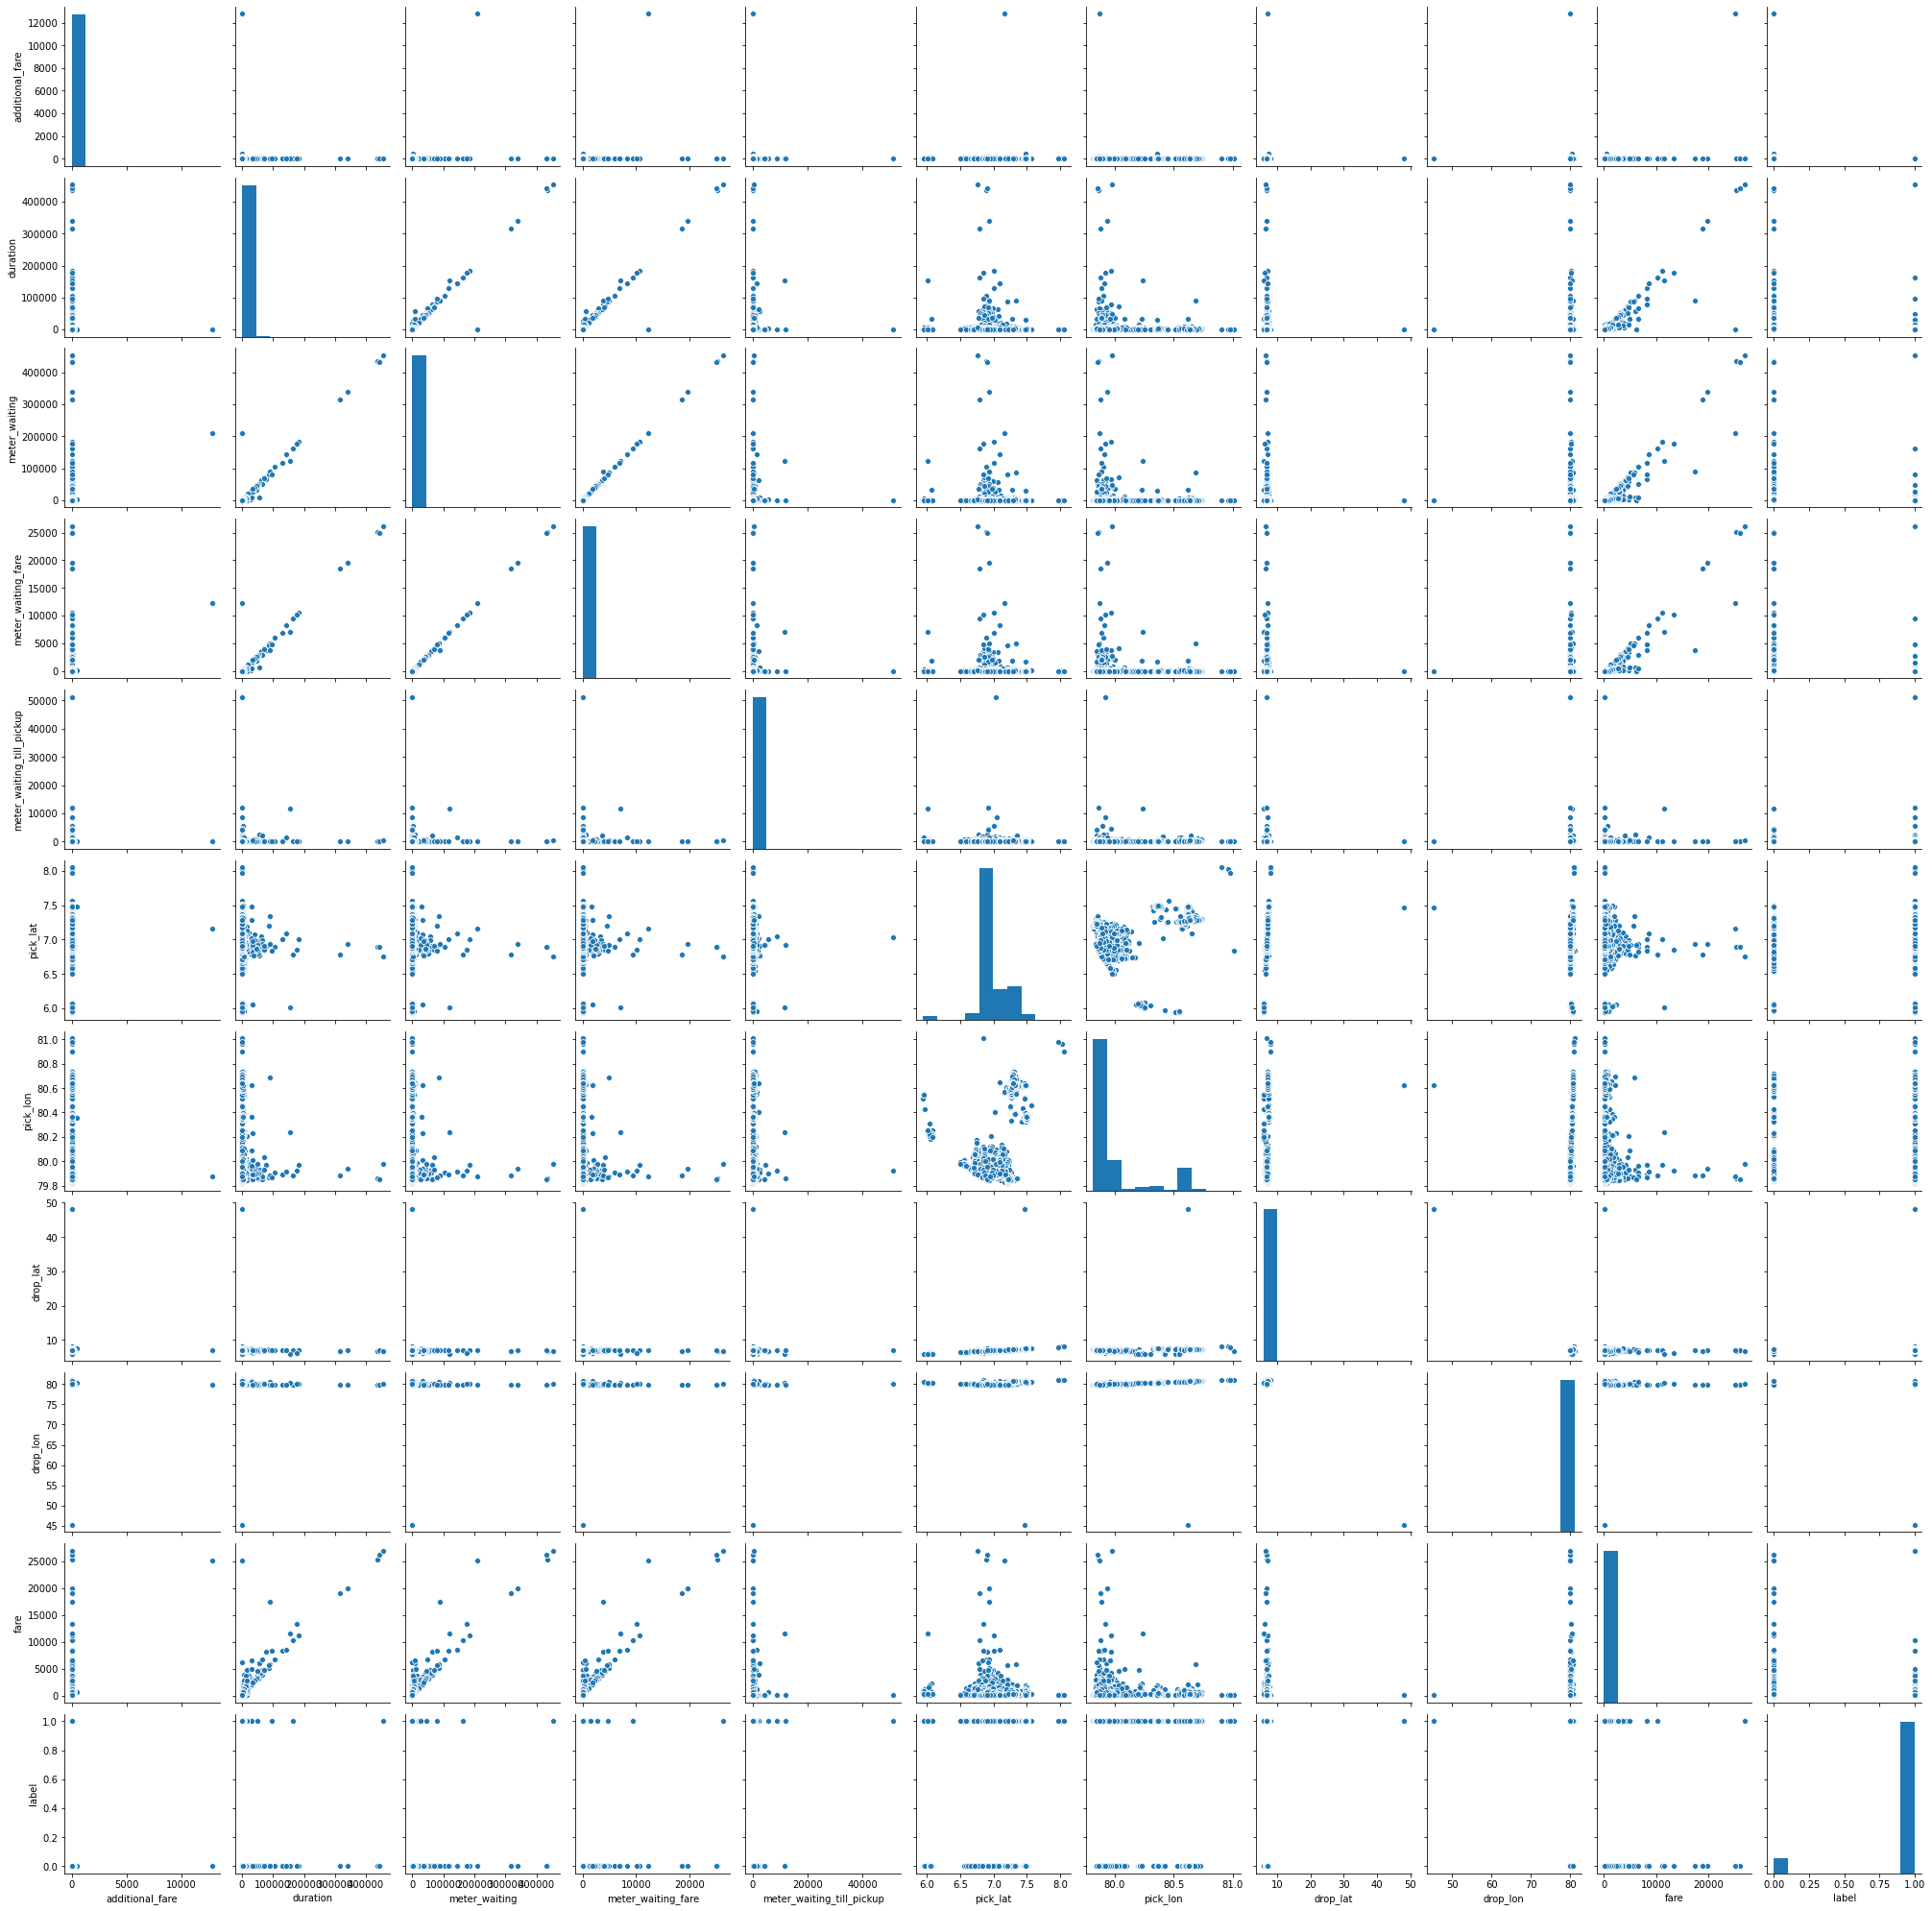

In [14]:
train_chart = train[[ 'additional_fare', 'duration', 'meter_waiting',
       'meter_waiting_fare', 'meter_waiting_till_pickup', 'pick_lat', 'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'label']]
sn.pairplot(train_chart)

In [15]:
train

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1
5,189129552,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17171,213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,1
17172,213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,1
17173,213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,1
17174,213815405,10.5,858.0,115.0,0.0000,317.0,1/31/2020 23:39,1/31/2020 23:53,6.94540,79.8768,6.93574,79.9010,133.31,1


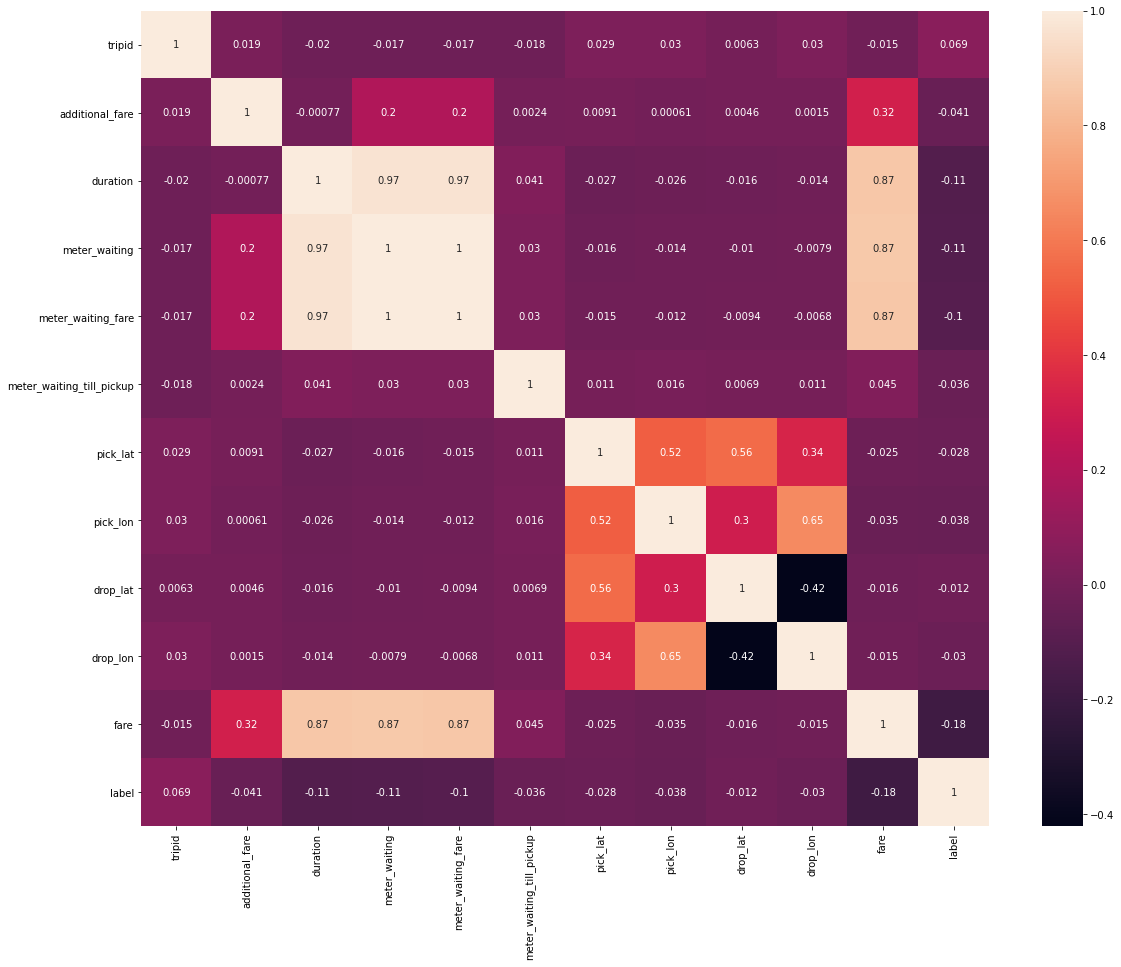

In [16]:
corrMatrix = train.corr()
plt.figure(figsize=(19,15))
sn.heatmap(corrMatrix, annot=True)


In [17]:
x = train[[ 'tripid', 'additional_fare', 'duration', 'meter_waiting',
       'meter_waiting_fare', 'meter_waiting_till_pickup', 'pick_lat', 'pick_lon', 'drop_lat', 'drop_lon', 'fare']]
y = train[['label']]

c:\users\xgent\pycharmprojects\datascience_project\venv\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[0.06787769 0.0303936  0.27270927 0.09339511 0.05540395 0.06611979
 0.06322105 0.06210782 0.06313555 0.06211284 0.16352335]


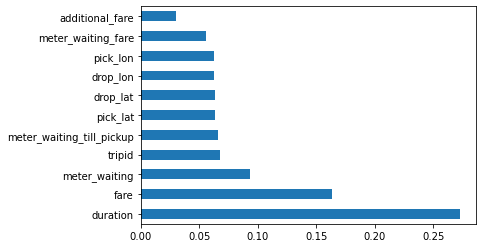

In [18]:

import matplotlib.pyplot as plt
model = RandomForestClassifier()
model.fit(x,y)
print(model.feature_importances_)


feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [19]:
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',                                                                 ascending=False)
feature_importances

,importance
duration,0.272709
fare,0.163523
meter_waiting,0.093395
tripid,0.067878
meter_waiting_till_pickup,0.066120
pick_lat,0.063221
drop_lat,0.063136
drop_lon,0.062113
pick_lon,0.062108
meter_waiting_fare,0.055404


# .............  Develop New Features

In [20]:
train["lon_diff"] = train["drop_lon"] - train["pick_lon"]
train["lat_diff"] = train["drop_lat"] - train["pick_lat"]
train.columns

Index(['tripid', 'additional_fare', 'duration', 'meter_waiting',
       'meter_waiting_fare', 'meter_waiting_till_pickup', 'pickup_time',
       'drop_time', 'pick_lat', 'pick_lon', 'drop_lat', 'drop_lon', 'fare',
       'label', 'lon_diff', 'lat_diff'],
      dtype='object')

In [21]:
train["linear_distance"] = ((train["lon_diff"] * train["lon_diff"]) + (train["lat_diff"] * train["lat_diff"]))**(1/2)
train

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,lon_diff,lat_diff,linear_distance
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1,-0.0210,0.04078,0.045869
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1,-0.0061,0.02784,0.028500
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1,0.0495,0.02830,0.057019
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1,0.0076,0.00178,0.007806
5,189129552,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,1,-0.0320,-0.21537,0.217734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17171,213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,1,0.0190,-0.00182,0.019087
17172,213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,1,0.0873,0.04520,0.098307
17173,213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,1,0.0017,0.00925,0.009405
17174,213815405,10.5,858.0,115.0,0.0000,317.0,1/31/2020 23:39,1/31/2020 23:53,6.94540,79.8768,6.93574,79.9010,133.31,1,0.0242,-0.00966,0.026057


In [22]:
train["time_diff"] = (pd.to_datetime(train["drop_time"]) - pd.to_datetime(train["pickup_time"])).astype(np.int64)
train

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,lon_diff,lat_diff,linear_distance,time_diff
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1,-0.0210,0.04078,0.045869,840000000000
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1,-0.0061,0.02784,0.028500,780000000000
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1,0.0495,0.02830,0.057019,1080000000000
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1,0.0076,0.00178,0.007806,600000000000
5,189129552,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,1,-0.0320,-0.21537,0.217734,3420000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17171,213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,1,0.0190,-0.00182,0.019087,840000000000
17172,213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,1,0.0873,0.04520,0.098307,2160000000000
17173,213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,1,0.0017,0.00925,0.009405,240000000000
17174,213815405,10.5,858.0,115.0,0.0000,317.0,1/31/2020 23:39,1/31/2020 23:53,6.94540,79.8768,6.93574,79.9010,133.31,1,0.0242,-0.00966,0.026057,840000000000


In [23]:
train["pickup_hour"] = pd.to_datetime(train["pickup_time"]).dt.hour
train

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,lon_diff,lat_diff,linear_distance,time_diff,pickup_hour
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1,-0.0210,0.04078,0.045869,840000000000,0
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1,-0.0061,0.02784,0.028500,780000000000,0
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1,0.0495,0.02830,0.057019,1080000000000,1
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1,0.0076,0.00178,0.007806,600000000000,2
5,189129552,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,1,-0.0320,-0.21537,0.217734,3420000000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17171,213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,1,0.0190,-0.00182,0.019087,840000000000,22
17172,213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,1,0.0873,0.04520,0.098307,2160000000000,23
17173,213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,1,0.0017,0.00925,0.009405,240000000000,23
17174,213815405,10.5,858.0,115.0,0.0000,317.0,1/31/2020 23:39,1/31/2020 23:53,6.94540,79.8768,6.93574,79.9010,133.31,1,0.0242,-0.00966,0.026057,840000000000,23


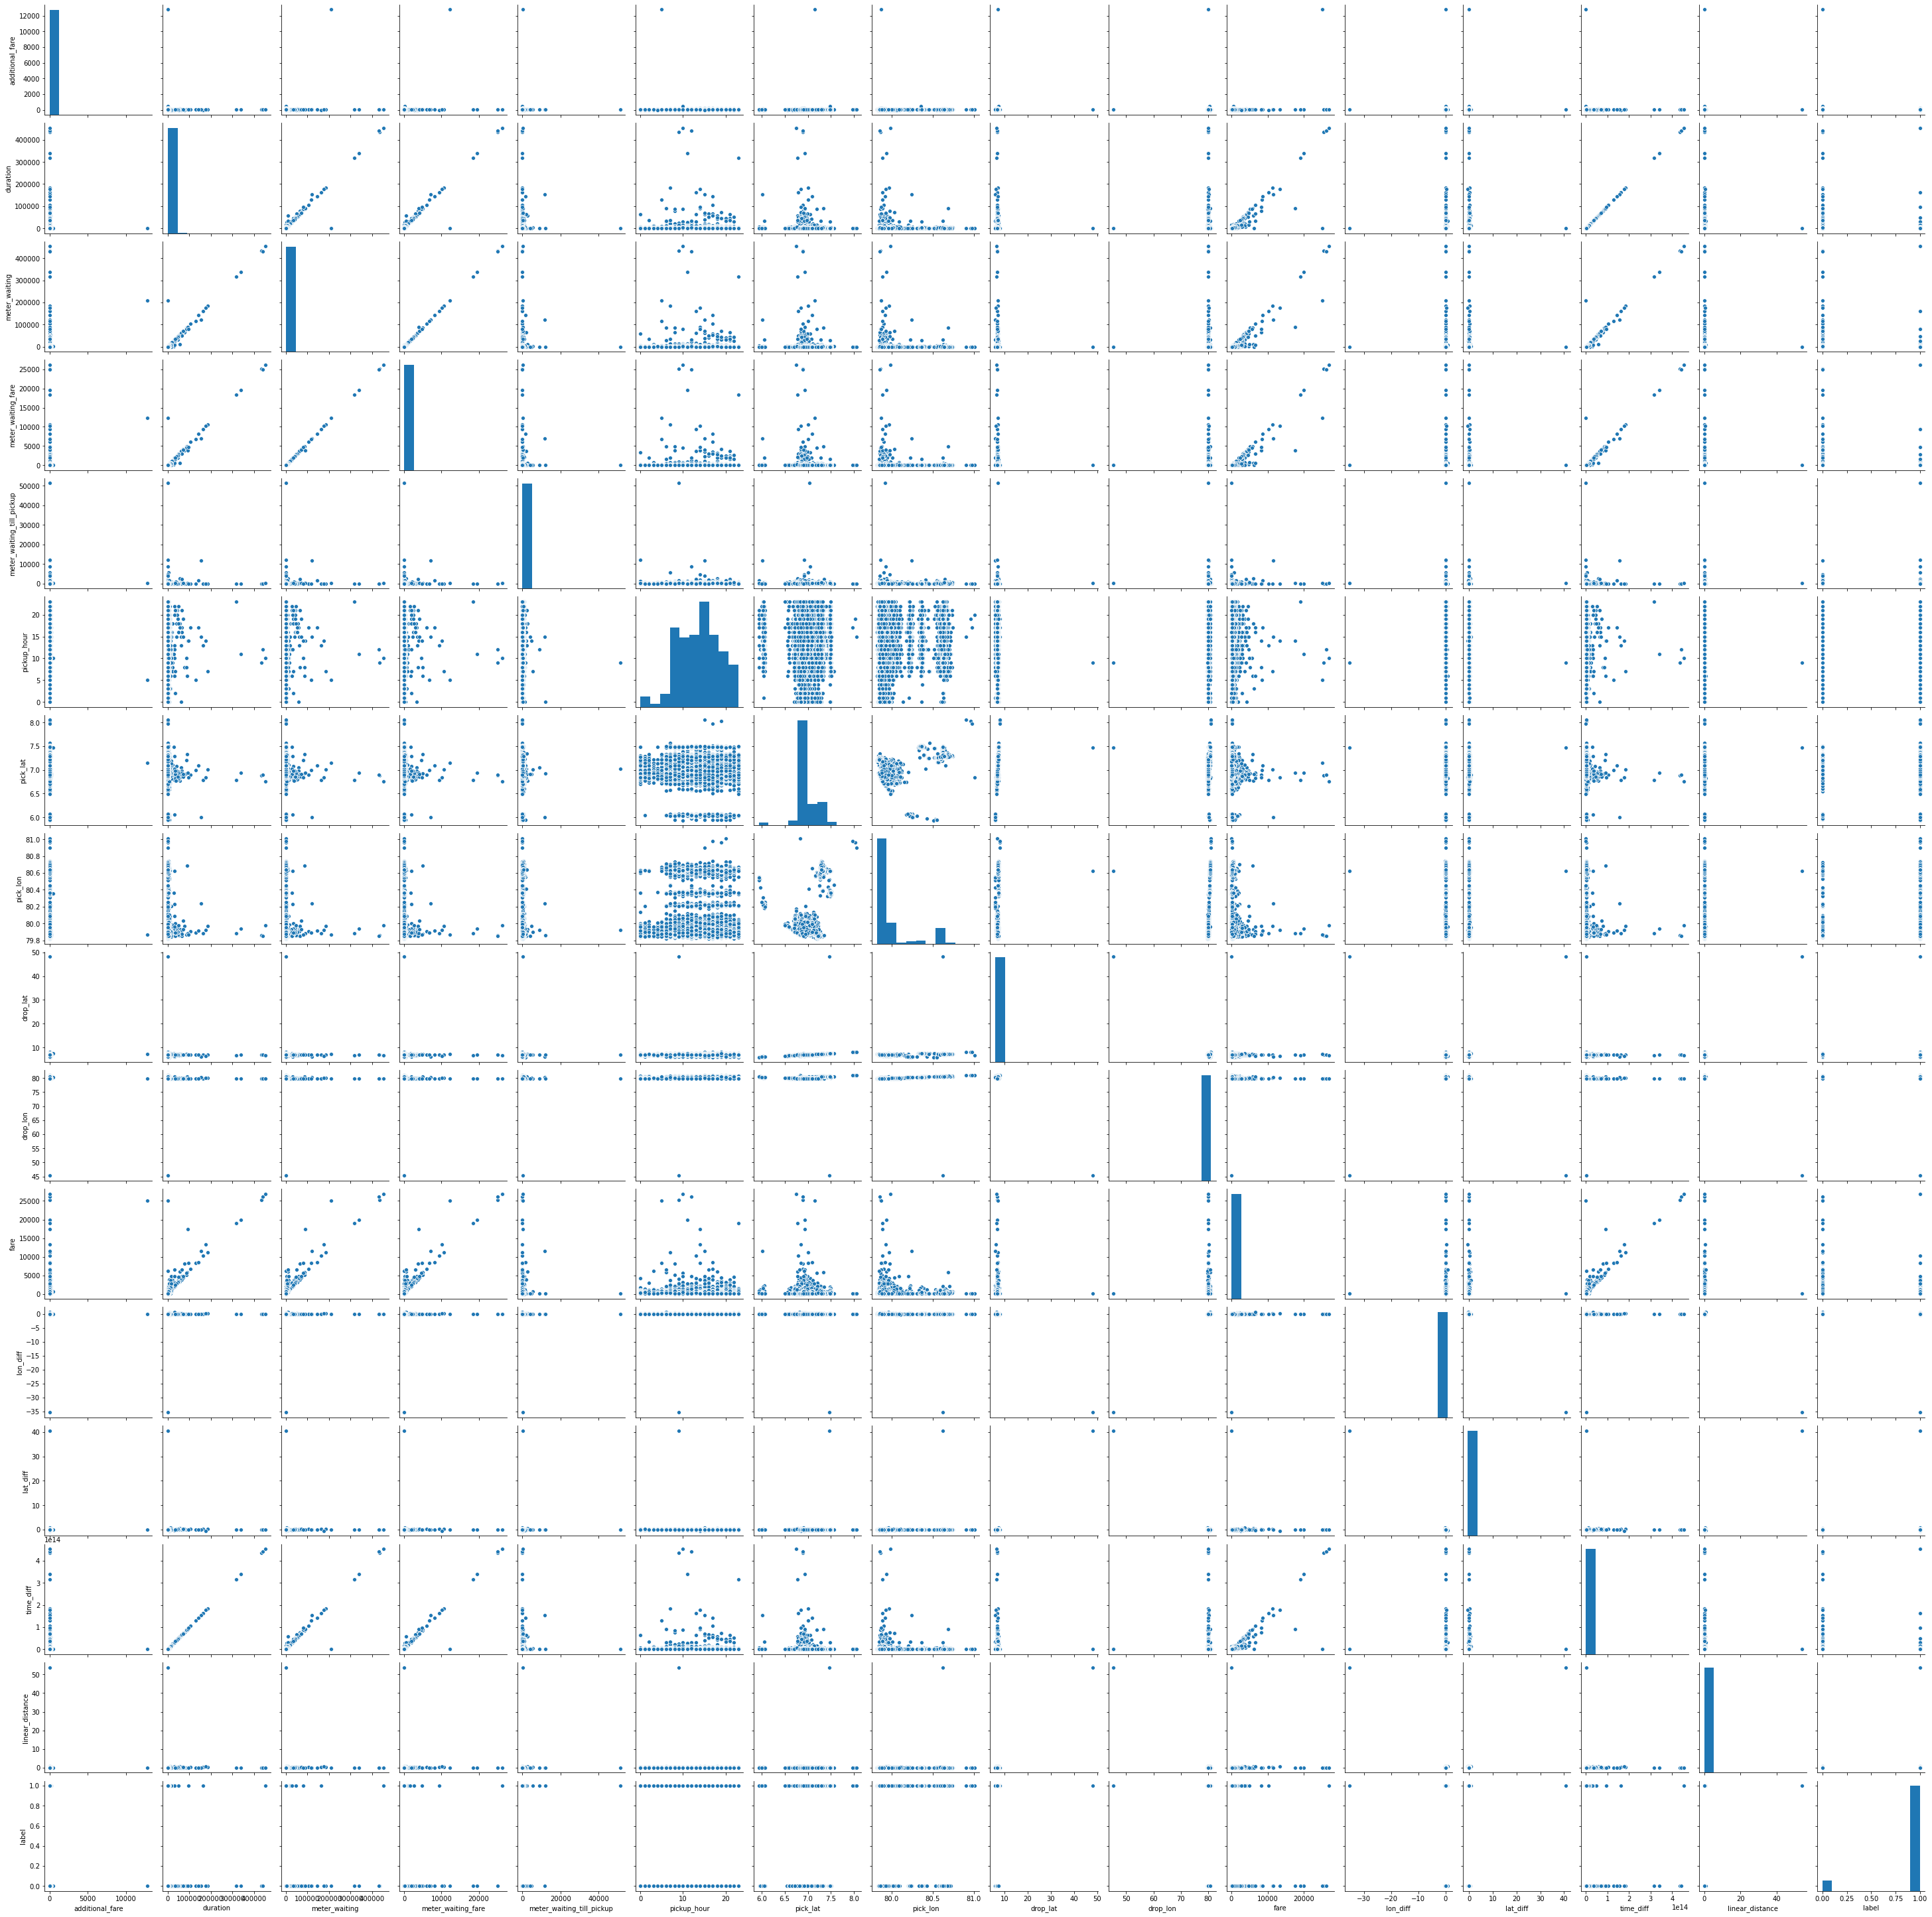

In [24]:
train_chart = train[['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup','pickup_hour',
        'pick_lat', 'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'lon_diff', 'lat_diff','time_diff', 'linear_distance', 'label']]
sn.pairplot(train_chart)


In [25]:
x = train[[ 'tripid', 'additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup','pickup_hour',
        'pick_lat', 'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'lon_diff', 'lat_diff','time_diff', 'linear_distance']]
y = train[['label']]

c:\users\xgent\pycharmprojects\datascience_project\venv\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[0.04409679 0.02562732 0.13805002 0.06927873 0.04284675 0.0436967
 0.02578729 0.03634315 0.03560261 0.03477144 0.03676954 0.15168129
 0.04308603 0.04509015 0.11425002 0.11302218]


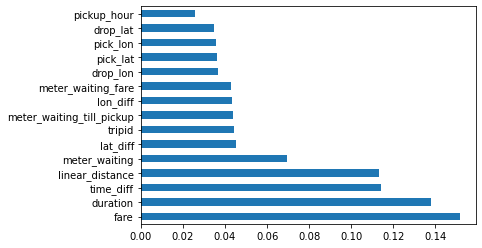

In [26]:
import matplotlib.pyplot as plt
model = RandomForestClassifier()
model.fit(x,y)
print(model.feature_importances_)

feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [27]:
#features = ['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
#                   'meter_waiting_till_pickup','fare','lon_diff', 'lat_diff','time_diff']
features = ['additional_fare', 'duration', 'meter_waiting',
       'meter_waiting_fare', 'meter_waiting_till_pickup','fare','lon_diff', 'lat_diff','time_diff','pickup_hour'] #Confidence: 0.9495187585935966
#features = ['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup','pickup_hour',
#        'pick_lat', 'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'lon_diff', 'lat_diff','time_diff', 'linear_distance']
# features = ['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup','fare',
#             'lon_diff', 'lat_diff','time_diff', 'linear_distance'] #Confidence: 0.9534472598703595
#features = ['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup','fare',
#             'lon_diff', 'lat_diff','time_diff'] #Confidence: 0.948733058338244

In [28]:
x = train[features]
y = train[['label']]

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [30]:
clf =RandomForestClassifier()
clf.fit(x_train,y_train)

c:\users\xgent\pycharmprojects\datascience_project\venv\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
confidence = clf.score(x_test, y_test)
print("Confidence:",confidence)

Confidence: 0.950108033785111


In [32]:
y_pred=clf.predict(x_test)

In [33]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.950108033785111


In [34]:
# train, validate, test = np.split(train.sample(frac=1), [int(.6*len(train)), int(.8*len(train))])
#
# x_train = train[features]
# y_train = train[['label']]
#
# x_validation = train[features]
# y_validation = train[['label']]
#
# x_test = train[features]
# y_test = train[['label']]
#
# x_train = x_train.values.reshape((x_train.shape[0], 1, x_train.shape[1]))
# x_validation = x_validation.values.reshape((x_validation.shape[0], 1, x_validation.shape[1]))
# x_test = x_test.values.reshape((x_test.shape[0], 1, x_test.shape[1]))
#
#
# print(x_train.shape, y_train.shape, x_validation.shape, y_validation.shape, x_test.shape, y_test.shape)
#
#
# #for velosity
# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape=(1, 10)))
# model.add(Dropout(0.2))
# model.add(LSTM(128))
# model.add(Dropout(0.1))
# model.add(Dense(1))
# model.compile(loss='mean_absolute_error', optimizer='adam')
# model.fit(x_train, y_train)
#
# history = model.fit(x_train, y_train, epochs=20, batch_size=5, validation_data=(x_validation, y_validation), verbose=1, shuffle=False)
#
# y_pred = model.predict(x_test, verbose=0)


In [35]:
# y_test
#

In [36]:
# y_pred.head
#

In [37]:
# print("Accuracy:",metrics.accuracy_score(y_test.values, y_pred.))

In [38]:
x = train[features]
y = train[['label']]

In [39]:
clf_final =RandomForestClassifier()
clf_final.fit(x,y)

c:\users\xgent\pycharmprojects\datascience_project\venv\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [40]:
test =  pd.read_csv('test.csv')

In [41]:
test.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
0,213284604,10.5,924,42,2.4486,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
1,213286352,10.5,4249,20,0.0000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
2,213293973,10.5,1552,255,2.6588,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
3,213294622,10.5,462,16,0.0000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
4,213298687,10.5,814,392,12.3692,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47


In [42]:
test.shape

(8576, 13)

In [43]:
test.isnull().sum().sum()

0

In [44]:
tripid = test['tripid']

In [45]:
test["lon_diff"] = test["drop_lon"] - test["pick_lon"]
test["lat_diff"] = test["drop_lat"] - test["pick_lat"]
test.columns

Index(['tripid', 'additional_fare', 'duration', 'meter_waiting',
       'meter_waiting_fare', 'meter_waiting_till_pickup', 'pickup_time',
       'drop_time', 'pick_lat', 'pick_lon', 'drop_lat', 'drop_lon', 'fare',
       'lon_diff', 'lat_diff'],
      dtype='object')

In [46]:
test["linear_distance"] = ((test["lon_diff"] * test["lon_diff"]) + (test["lat_diff"] * test["lat_diff"]))**(1/2)
test

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,lon_diff,lat_diff,linear_distance
0,213284604,10.5,924,42,2.44860,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27,0.0090,-0.05964,0.060315
1,213286352,10.5,4249,20,0.00000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70,0.0983,-0.36077,0.373922
2,213293973,10.5,1552,255,2.65880,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00,0.0511,-0.01606,0.053564
3,213294622,10.5,462,16,0.00000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32,-0.0009,0.02968,0.029694
4,213298687,10.5,814,392,12.36920,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47,-0.0216,0.00907,0.023427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8571,222856243,10.5,1723,429,24.83332,3,3/16/2020 21:28,3/16/2020 21:56,6.85103,79.9567,6.85588,79.9214,388.48,-0.0353,0.00485,0.035632
8572,222857785,10.5,1378,80,0.00000,125,3/16/2020 21:59,3/16/2020 22:22,6.91293,79.9656,6.92112,79.8980,379.85,-0.0676,0.00819,0.068094
8573,222858416,10.5,418,56,3.28440,93,3/16/2020 22:02,3/16/2020 22:09,6.85718,79.9081,6.83868,79.9083,112.79,0.0002,-0.01850,0.018501
8574,222858691,10.5,1604,548,31.67440,17,3/16/2020 22:07,3/16/2020 22:34,6.91289,79.8846,6.93159,79.9145,248.46,0.0299,0.01870,0.035266


In [47]:
test["time_diff"] = (pd.to_datetime(test["drop_time"]) - pd.to_datetime(test["pickup_time"])).astype(np.int64)
test

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,lon_diff,lat_diff,linear_distance,time_diff
0,213284604,10.5,924,42,2.44860,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27,0.0090,-0.05964,0.060315,900000000000
1,213286352,10.5,4249,20,0.00000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70,0.0983,-0.36077,0.373922,4260000000000
2,213293973,10.5,1552,255,2.65880,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00,0.0511,-0.01606,0.053564,1560000000000
3,213294622,10.5,462,16,0.00000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32,-0.0009,0.02968,0.029694,480000000000
4,213298687,10.5,814,392,12.36920,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47,-0.0216,0.00907,0.023427,840000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8571,222856243,10.5,1723,429,24.83332,3,3/16/2020 21:28,3/16/2020 21:56,6.85103,79.9567,6.85588,79.9214,388.48,-0.0353,0.00485,0.035632,1680000000000
8572,222857785,10.5,1378,80,0.00000,125,3/16/2020 21:59,3/16/2020 22:22,6.91293,79.9656,6.92112,79.8980,379.85,-0.0676,0.00819,0.068094,1380000000000
8573,222858416,10.5,418,56,3.28440,93,3/16/2020 22:02,3/16/2020 22:09,6.85718,79.9081,6.83868,79.9083,112.79,0.0002,-0.01850,0.018501,420000000000
8574,222858691,10.5,1604,548,31.67440,17,3/16/2020 22:07,3/16/2020 22:34,6.91289,79.8846,6.93159,79.9145,248.46,0.0299,0.01870,0.035266,1620000000000


In [48]:
test["pickup_hour"] = pd.to_datetime(test["pickup_time"]).dt.hour
test

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,lon_diff,lat_diff,linear_distance,time_diff,pickup_hour
0,213284604,10.5,924,42,2.44860,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27,0.0090,-0.05964,0.060315,900000000000,0
1,213286352,10.5,4249,20,0.00000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70,0.0983,-0.36077,0.373922,4260000000000,1
2,213293973,10.5,1552,255,2.65880,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00,0.0511,-0.01606,0.053564,1560000000000,5
3,213294622,10.5,462,16,0.00000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32,-0.0009,0.02968,0.029694,480000000000,5
4,213298687,10.5,814,392,12.36920,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47,-0.0216,0.00907,0.023427,840000000000,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8571,222856243,10.5,1723,429,24.83332,3,3/16/2020 21:28,3/16/2020 21:56,6.85103,79.9567,6.85588,79.9214,388.48,-0.0353,0.00485,0.035632,1680000000000,21
8572,222857785,10.5,1378,80,0.00000,125,3/16/2020 21:59,3/16/2020 22:22,6.91293,79.9656,6.92112,79.8980,379.85,-0.0676,0.00819,0.068094,1380000000000,21
8573,222858416,10.5,418,56,3.28440,93,3/16/2020 22:02,3/16/2020 22:09,6.85718,79.9081,6.83868,79.9083,112.79,0.0002,-0.01850,0.018501,420000000000,22
8574,222858691,10.5,1604,548,31.67440,17,3/16/2020 22:07,3/16/2020 22:34,6.91289,79.8846,6.93159,79.9145,248.46,0.0299,0.01870,0.035266,1620000000000,22


In [49]:
test = test[features]

In [50]:
test.shape

(8576, 10)

In [51]:
result = clf_final.predict(test)

In [52]:
result=pd.DataFrame(result, columns=['prediction'])

In [53]:
result.head()

,prediction
0,1
1,1
2,1
3,1
4,1


In [54]:
test['prediction'] = result['prediction']

c:\users\xgent\pycharmprojects\datascience_project\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
test.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,lon_diff,lat_diff,time_diff,pickup_hour,prediction
0,10.5,924,42,2.4486,148,289.27,0.0090,-0.05964,900000000000,0,1
1,10.5,4249,20,0.0000,91,1912.70,0.0983,-0.36077,4260000000000,1,1
2,10.5,1552,255,2.6588,23,394.00,0.0511,-0.01606,1560000000000,5,1
3,10.5,462,16,0.0000,198,154.32,-0.0009,0.02968,480000000000,5,1
4,10.5,814,392,12.3692,69,147.47,-0.0216,0.00907,840000000000,7,1


In [56]:
test['tripid'] =  tripid 

c:\users\xgent\pycharmprojects\datascience_project\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [57]:
test

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,lon_diff,lat_diff,time_diff,pickup_hour,prediction,tripid
0,10.5,924,42,2.44860,148,289.27,0.0090,-0.05964,900000000000,0,1,213284604
1,10.5,4249,20,0.00000,91,1912.70,0.0983,-0.36077,4260000000000,1,1,213286352
2,10.5,1552,255,2.65880,23,394.00,0.0511,-0.01606,1560000000000,5,1,213293973
3,10.5,462,16,0.00000,198,154.32,-0.0009,0.02968,480000000000,5,1,213294622
4,10.5,814,392,12.36920,69,147.47,-0.0216,0.00907,840000000000,7,1,213298687
...,...,...,...,...,...,...,...,...,...,...,...,...
8571,10.5,1723,429,24.83332,3,388.48,-0.0353,0.00485,1680000000000,21,1,222856243
8572,10.5,1378,80,0.00000,125,379.85,-0.0676,0.00819,1380000000000,21,1,222857785
8573,10.5,418,56,3.28440,93,112.79,0.0002,-0.01850,420000000000,22,1,222858416
8574,10.5,1604,548,31.67440,17,248.46,0.0299,0.01870,1620000000000,22,1,222858691


In [58]:
test[[ "tripid","prediction"]].to_csv('submission.csv', index = False)